# Kernel Principal component analysis (PCA) from scratch

Kernel PCA is a generalization of PCA allowing the extracting of non-linear relationships

In [1]:
using PyPlot
using Random
using LinearAlgebra
using Statistics
using Test

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


Some sample data from sklean

In [2]:
# adapted from https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/datasets/_samples_generator.py#L649
# BSD 3 clause
# by https://github.com/scikit-learn/scikit-learn/blame/137b4dd6bd7308461f1be7086f6bfdc7ecf4bd23/sklearn/datasets/samples_generator.py

function make_moon(; n_samples = 100, shuffle = true)
    n_samples_out = n_samples ÷ 2
    n_samples_in = n_samples - n_samples_out

    X = zeros(2,n_samples)
    y = zeros(n_samples)

    # outer circle
    X[1,1:n_samples_out] = cos.(LinRange(0, π, n_samples_out))
    X[2,1:n_samples_out] = sin.(LinRange(0, π, n_samples_out))
    y[1:n_samples_out] .= 0

    # inner circle
    X[1,n_samples_out+1:end] = 1 .- cos.(LinRange(0, π, n_samples_in))
    X[2,n_samples_out+1:end] = 1 .- sin.(LinRange(0, π, n_samples_in)) .- 0.5
    y[n_samples_out+1:end] .= 1

    if shuffle
       ind = randperm(n_samples)
       return X[:,ind],y[ind]
    else
       return X,y
    end
end

N = 100
X,y = make_moon(n_samples = N) 

([0.07308324265397825 1.0960230259076817 … -0.6723008902613169 0.9917900138232462; 0.12473299512062597 -0.49537911294919823 … 0.7402779970753155 0.127877161684506], [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0])

Choose your favourite [colormap](https://matplotlib.org/users/colormaps.html).

In [3]:
PyPlot.plt.rc("image", cmap = "RdYlBu_r")

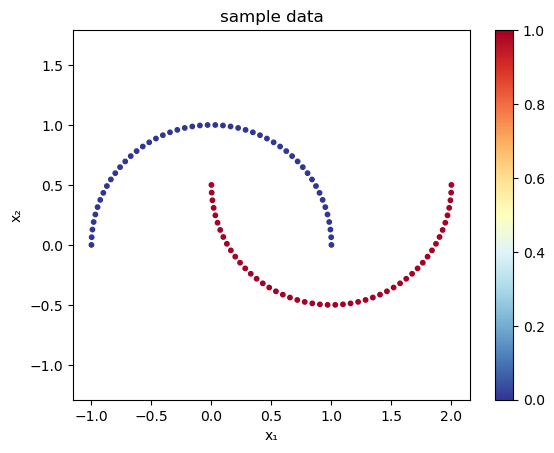

In [4]:
title("sample data")
scatter(X[1,:],X[2,:],10,y); colorbar();
xlabel("x₁")
ylabel("x₂")
axis("equal");

# Principal component analysis or Empirial orthogonal functions 

$\renewcommand{\vec}{\mathbf}$
$\newcommand{\mat}{\mathbf}$

Assume that we have $\vec x_i$ vectors ($\vec x_i \in ℝ^D$) for $i=1\,\dots,N$.

Generally we remove the time mean:

$$
\bar{\vec x} = \frac{1}{N} \sum_{i=1}^N \vec x_i
$$

Anomalies:

$$
\vec x'_i = \vec x_i - \bar{\vec x}
$$

One can also intruce a $D \times N$ matrix $\mat X$ whoes i-th column is $\vec x_i$. The anomaly matrix 
$\mat X'$:

$$
\mat X' = \mat X - \mat X \, \mat 1_N
$$

where $ \mat 1_N$ is a $N \times N$ matrix with all elements equation to $1/N$.
One way to derive the PCA is to compute the SVD decomposition of $\mat X'$:

$$
\mat X' = \mat U \, \mat \Sigma \, \mat V^T
$$

where $\mat U^T \mat U = \mat I$, $\mat V^T \mat V = \mat I$ and $\mat \Sigma$ is a diagonal matrix with the singular values (note $\sigma_k$ for $k=1\dots,N$).

Alternatively, one can also derive the eigenvectors by using the eigendecomposition of the covariance matrix $\mat X' \mat X'^T$

$$
\mat X' \mat X'^T = \mat U \mat \Lambda_U \mat U'
$$

or the matrix $\mat X'^T \mat X'$

$$
\mat X'^T \mat X' = \mat V \mat \Lambda_V \mat V'
$$

Note that the nonzero eigenvalues in $\Lambda_V $ are identical to the nonzero eigenvalues in $\Lambda_U$. If, for example, $\mat V$ is known, then $\mat U$ can be computed by:

$$
\mat U = \mat X' \mat V  (\mat \Lambda_V)^{-\frac{1}{2}}
$$


Any vector can be written as

$$
\vec x'_i = \sum_{k=1}^{N} \vec u_k a_{ki}
$$

where $\vec u_k$ is the k-th column of $\mat U$ and $a_{ki} = \sigma_k V_{ik}$

Important aspect: truncation, optimal basis function

In [5]:
Xa = X .- mean(X,dims=2);
U,Σ,V = svd(Xa);

@test Xa ≈ U * Diagonal(Σ) * V'

Test Passed

In [6]:
@test Xa*Xa' ≈ U * Diagonal(Σ)^2 * U'

Test Passed

In [7]:
Σ

2-element Array{Float64,1}:
 9.056660957614422
 4.247729967201448

One can also compute the PCA/EOF using an eigenvector decomposition. The order of the eigenvalues/eigenvector might be different.

In [8]:
Λ,V = eigen(Symmetric(Xa'*Xa),N-1:N)
# sort in decreasing order
Λ = reverse(Λ)
V = reverse(V,dims=2)
Σ = sqrt.(Λ)
U = Xa * V * inv(Diagonal(Σ))

@test Xa ≈ U * Diagonal(Σ) * V'

Test Passed

In [9]:
@test Xa*Xa' ≈ U * Diagonal(Λ) * U' 

Test Passed

In [10]:
@test Xa'*Xa ≈ V * Diagonal(Λ) * V' 

Test Passed

In [11]:
Σ

2-element Array{Float64,1}:
 9.056660957614424
 4.247729967201449

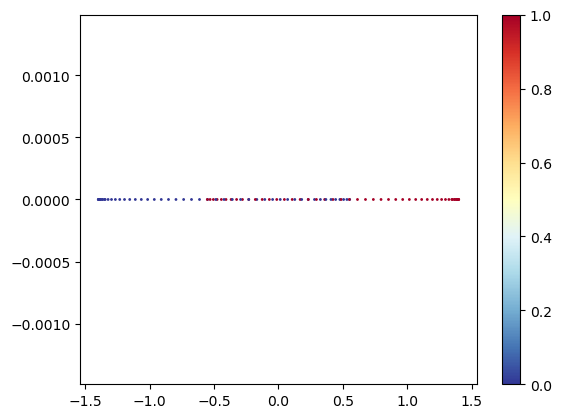

In [12]:
A = Diagonal(Σ) * V';

scatter(A[1,:],zeros(N),1,y); colorbar();

A traditional PCA does not allow to separate well the two circles from the sample data

# Kernel PCA

Assume a non-linear function $\phi: ℝ^D → ℝ^M$ mapping each $\vec x_i$ onto a high-dimensional state. Typically $M$ is much larger than $D$ and infact, $M$ can even be infinite.

For example, one could augment the vector $\vec x$ by the distance to the origin. If $\vec x = (x_1, x_2)^T$ then:

$$
\phi(\vec x) = (x_1,x_2, \sqrt{x_1^2 + x_2^2} )^T 
$$ 

The i-th column of $\tilde{\mat X}$ is equal as $\phi(\vec x_i)$

The anomalies are: 

$$
\tilde{\mat X}' = \tilde{\mat X} - \tilde{\mat X} \, \mat 1_N
$$

where $ \mat 1_N$ is a $N \times N$ matrix with all elements equation to $1/N$.
Since $M$ is typically much larger than $D$, it is useful to compute the PCA decomposition avoding matrices with the size the $M$. The matrix $\tilde{\mat X}'^T \tilde{\mat X}'$ is of size $N \times N$ and can be computed directly from $\tilde{\mat X}$:

$$
\tilde{\mat X}'^T \tilde{\mat X}' = \tilde{\mat X}^T \tilde{\mat X}
-  \mat 1_N^T \tilde{\mat X}^T \tilde{\mat X} 
-  \tilde{\mat X}^T \tilde{\mat X} \mat 1_N 
+  \mat 1_N^T \tilde{\mat X}^T \tilde{\mat X} \mat 1_N
=
\mat K
-  \mat 1_N^T \mat K
-  \mat K \mat 1_N 
+  \mat 1_N^T \mat K \mat 1_N
$$

where $\mat K = \tilde{\mat X}^T \tilde{\mat X}$. The elements of $\mat K$ are given by:

$$
K_{ij} = \phi(\vec x_i) \cdot \phi(\vec x_j) = k(\vec x_i, \vec x_j)
$$

The function defining inner product is called kernel function $k(\cdot,\cdot)$. The kernel function is:
* symetric $k(\vec x, \vec x') = k(\vec x', \vec x)$ for all $\vec x$, $\vec x'$ and 
* semi-positive definite $k(\vec x, \vec x) \le 0$ for all $\vec x$ 

In particse, it is not necessary to know the function $\phi(\cdot)$, just the kernel function $k$.


Various kernel functions are possible in practice. The following one is the radial Gaussian basis function which involved a parameter γ. The parameter is often determined by cross-validation.

In [13]:
#kernel(x,y) = x ⋅ y

const γ = 15
kernel(x,y) = exp( - γ * sum( (x - y).^2) )

kernel (generic function with 1 method)

In [14]:
function kernel_PCA(X,kernel,ncomp)
    N = size(X,2)
    K = zeros(N,N)

   for j = 1:N
      for i = 1:N
        K[i,j] = kernel(X[:,i],X[:,j])
      end
    end
    one_n = ones(N,N)/N
    # recenter K
    Kp = Symmetric(K - one_n * K - K * one_n + one_n * K * one_n)

    # eigendecomposition with the ncomp lagest eigenvalues
    Λ,V = eigen(Kp,N-ncomp+1:N);

    V = reverse(V,dims=2)
    Λ = reverse(Λ)

    Λ[Λ .< 0] .= 0

    λ = Λ/N

    amplitudes = Diagonal(sqrt.(Λ)) * V'

    return amplitudes, Λ, V, K
end

kernel_PCA (generic function with 1 method)

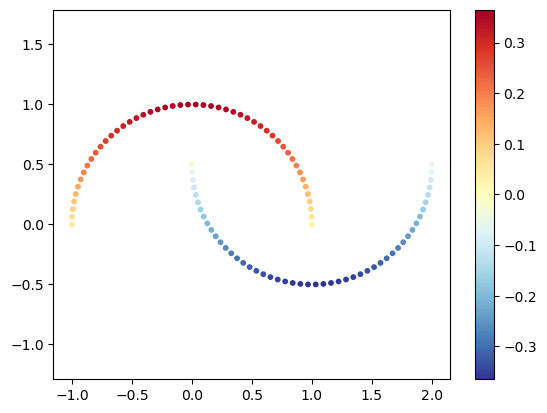

In [15]:
ncomp = 2
amplitudes, Λ, V, K = kernel_PCA(X,kernel,ncomp)

scatter(X[1,:],X[2,:],10,amplitudes[1,:])
axis("equal")
colorbar();

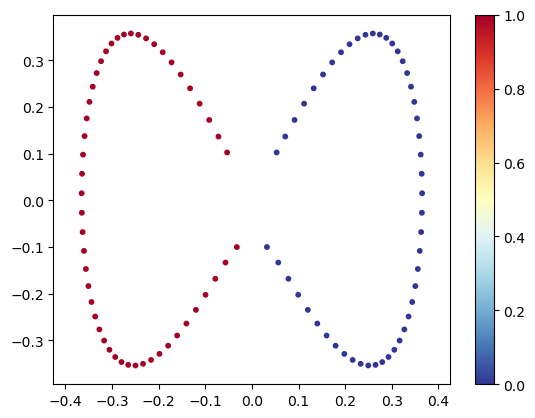

In [16]:
scatter(amplitudes[1,:],amplitudes[2,:],10,y)
axis("equal")
colorbar();

The different arcs are completelty separable using this kernel PCA:

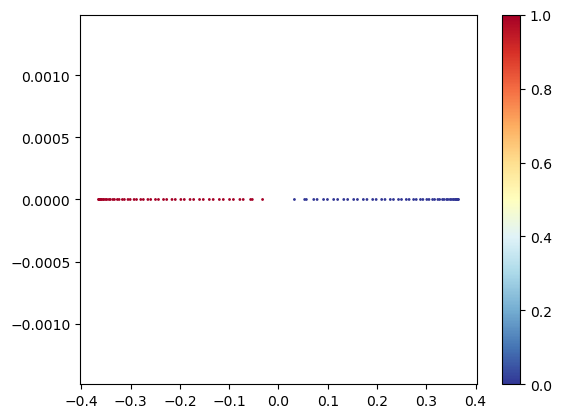

In [33]:
scatter(amplitudes[1,:],zeros(N),1,y); colorbar();

In [18]:
i = 1

1

In [19]:
amplitudes[:,i]

2-element Array{Float64,1}:
 -0.16016550640575966
 -0.2896758369427156

How to project any $\vec x$ (not used during the computation of the PCA)?

In [20]:
function project_x(Λ,V,K,X,x) 
    N = size(X,2)
    k = zeros(N,size(x,2))
    for i = 1:N
        for j = 1:size(x,2)
           k[i,j] = kernel(x[:,j],X[:,i])
        end
    end
    # center
    k = k .- mean(K,dims=2) .- mean(k,dims=1) .+ mean(K);
    return inv(sqrt(Diagonal(Λ))) * (V' * k )    
end

x_new = X[:,i]
project_x(Λ,V,K,X,x_new)


2×1 Array{Float64,2}:
 -0.1601655064057597
 -0.289675836942716

In [21]:
@test project_x(Λ,V,K,X,X[:,i]) ≈ amplitudes[:,i]

Test Passed

In [22]:
@test project_x(Λ,V,K,X,X[:,1:2]) ≈ amplitudes[:,1:2]

Test Passed

Helper function to plot grid

In [23]:
function plotgrid(g; alpha = 0.1, picki = 20, pickj = 30)
    plot(g[:,:,1],g[:,:,2],"k",alpha = alpha)
    plot(g[:,:,1]',g[:,:,2]',"k", alpha = alpha)

    plot(g[picki,:,1],g[picki,:,2],"r")
    plot(g[:,pickj,1],g[:,pickj,2],"b")
    axis("equal")
end

plotgrid (generic function with 1 method)

Size of the grid to plot

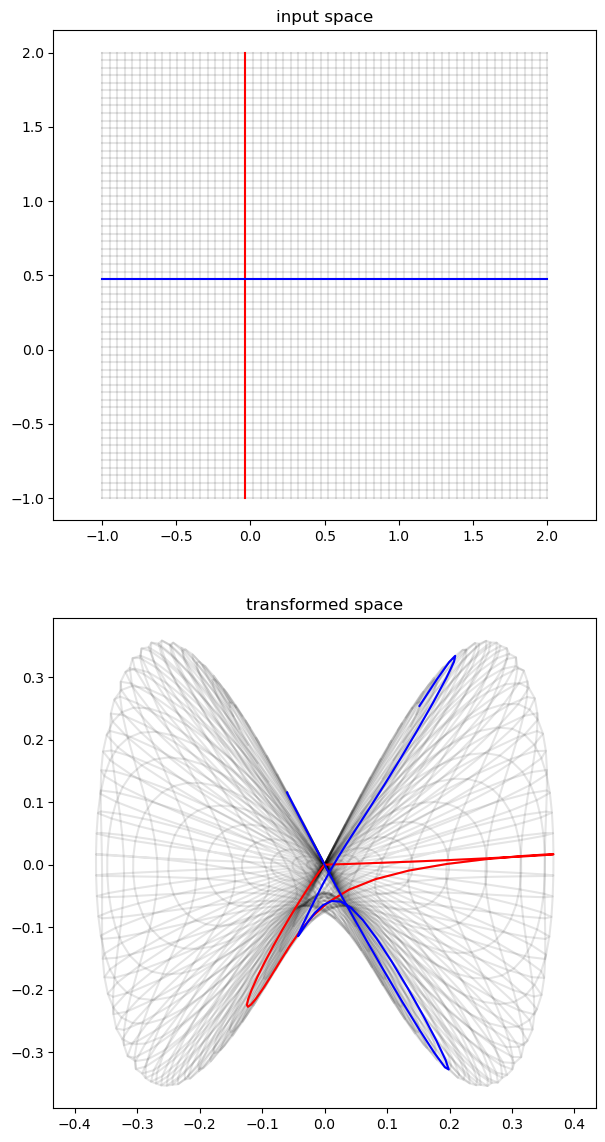

In [24]:
sz = (60,60)

linx = LinRange(-1,2,sz[1])
liny = LinRange(-1,2,sz[2])

gridx = zeros(sz...,2)
projected_gridx = zeros(sz...,2)

for i = 1:sz[1]
   for j = 1:sz[2]
       gridx[i,j,1] = linx[i]
       gridx[i,j,2] = liny[j]
        
       projected_gridx[i,j,:] =  project_x(Λ,V,K,X,gridx[i,j,:]);
    end
end

figure(figsize=(7,14))
subplot(2,1,1)
plotgrid(gridx)
title("input space")
subplot(2,1,2)
plotgrid(projected_gridx)
title("transformed space");

The kernel PCA is also implemented in the package MultivariateStats 

In [25]:
using MultivariateStats

┌ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
└ @ Base loading.jl:1260


In [26]:
const γ = 15

15

In [27]:
M = fit(KernelPCA, X; kernel = (x,y) -> exp(-γ*norm(x-y)^2), maxoutdim=2, inverse=true)
Yte = transform(M, X)

2×100 Array{Float64,2}:
 -0.160166  -0.364072   -0.274169  …  -0.358618  0.288048   0.0783589
 -0.289676   0.0570814   0.355664      0.137875  0.348466  -0.16798

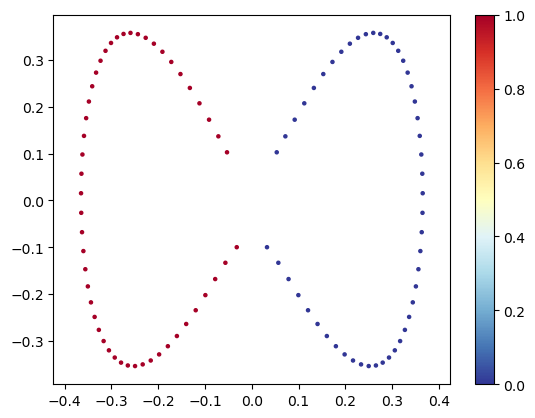

In [28]:
scatter(Yte[1,:],Yte[2,:],5,y)
colorbar()
axis("equal");

In [29]:
@test Yte[:,1] ≈ amplitudes[:,1]

Test Passed

In [30]:
Yte = transform(M, X[:,1])
@test Yte ≈ amplitudes[:,1]

Test Passed

In [31]:
Xr = reconstruct(M, Yte)

2×1 Array{Float64,2}:
 0.11426799318120669
 0.07407456893311355

In [32]:
X[:,1]

2-element Array{Float64,1}:
 0.07308324265397825
 0.12473299512062597

## References


Sebastian Raschka, 2014 Kernel tricks and nonlinear dimensionality reduction via RBF kernel PCA
https://sebastianraschka.com/Articles/2014_kernel_pca.html

Quan Wang, 2014:
Kernel Principal Component Analysis and its Applications in Face Recognition and Active Shape Models
https://arxiv.org/abs/1207.3538